In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, precision_recall_curve)

from imblearn.over_sampling import SMOTE

plt.style.use('fivethirtyeight')
sns.set_palette("Set2")

In [5]:
# Load
df = pd.read_csv("ai4i2020.csv")

print("Data Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\n Colunm list")
print(df.columns.tolist())

print("\nFailure Type Distribution:")
failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_columns].sum()

failure_mapping = {
    'TWF': 'Tool Wear Failure',
    'HDF': 'Heat Dissipation Failure',
    'PWF': 'Power Failure', 
    'OSF': 'Overstrain Failure',
    'RNF': 'Random Failures'
}

print("Individual failure type counts:")
for code, count in failure_counts.items():
    print(f"{failure_mapping[code]}: {count} occurrences")

print(f"\nTotal individual failure occurrences: {failure_counts.sum()}")


Data Shape: (10000, 14)

First few rows:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    

In [8]:
data = df.copy()

data['Power'] = data['Rotational speed [rpm]'] * data['Torque [Nm]']
data['Temperature_Ratio'] = data['Process temperature [K]'] / data['Air temperature [K]']
data['Tool_Wear_Rate'] = data['Tool wear [min]'] / (data['Air temperature [K]'] - 273.15)

le_type = LabelEncoder()
data['Type_encoded'] = le_type.fit_transform(data['Type'])

features = ['Air temperature [K]', 'Process temperature [K]', 
           'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
           'Power', 'Temperature_Ratio', 'Tool_Wear_Rate', 'Type_encoded']

X = data[features]
y = data['Machine failure']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Failure rate: {y.mean():.4f}")


Features shape: (10000, 9)
Target shape: (10000,)
Failure rate: 0.0339


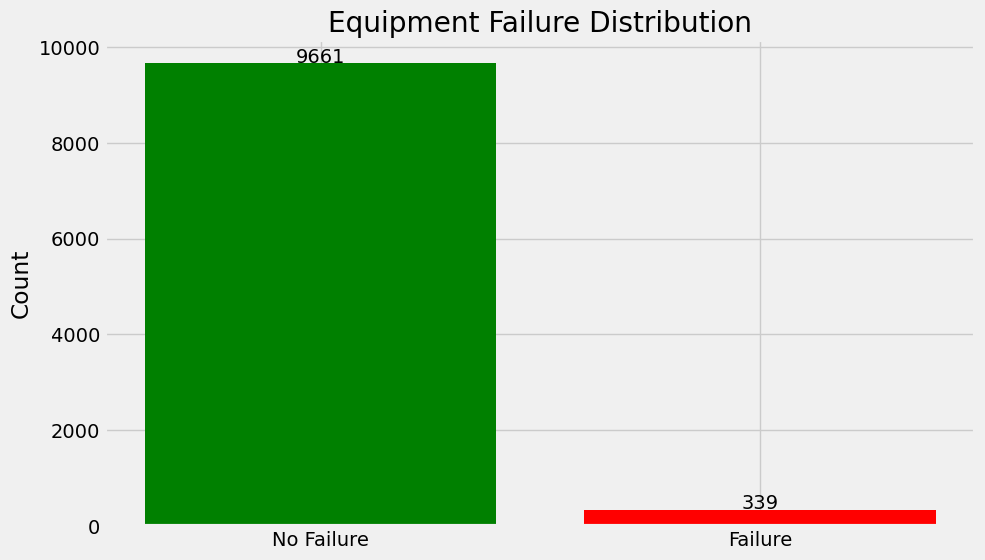

Failure rate: 3.39% (highly imbalanced)


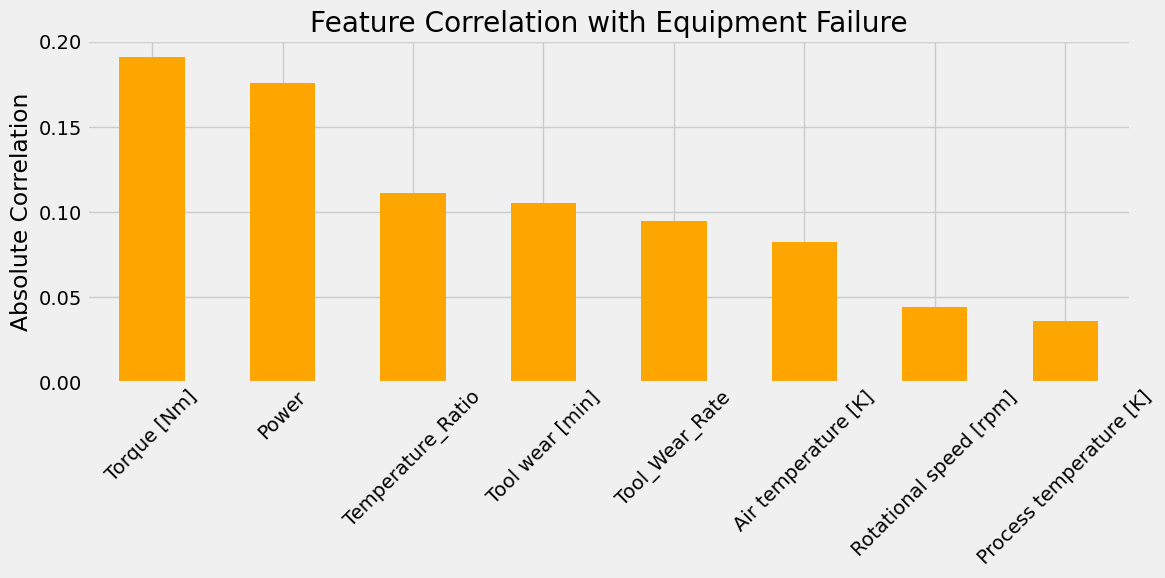

Top correlations with failure:
Torque [Nm]: 0.1913
Power: 0.1760
Temperature_Ratio: 0.1113
Tool wear [min]: 0.1054
Tool_Wear_Rate: 0.0951


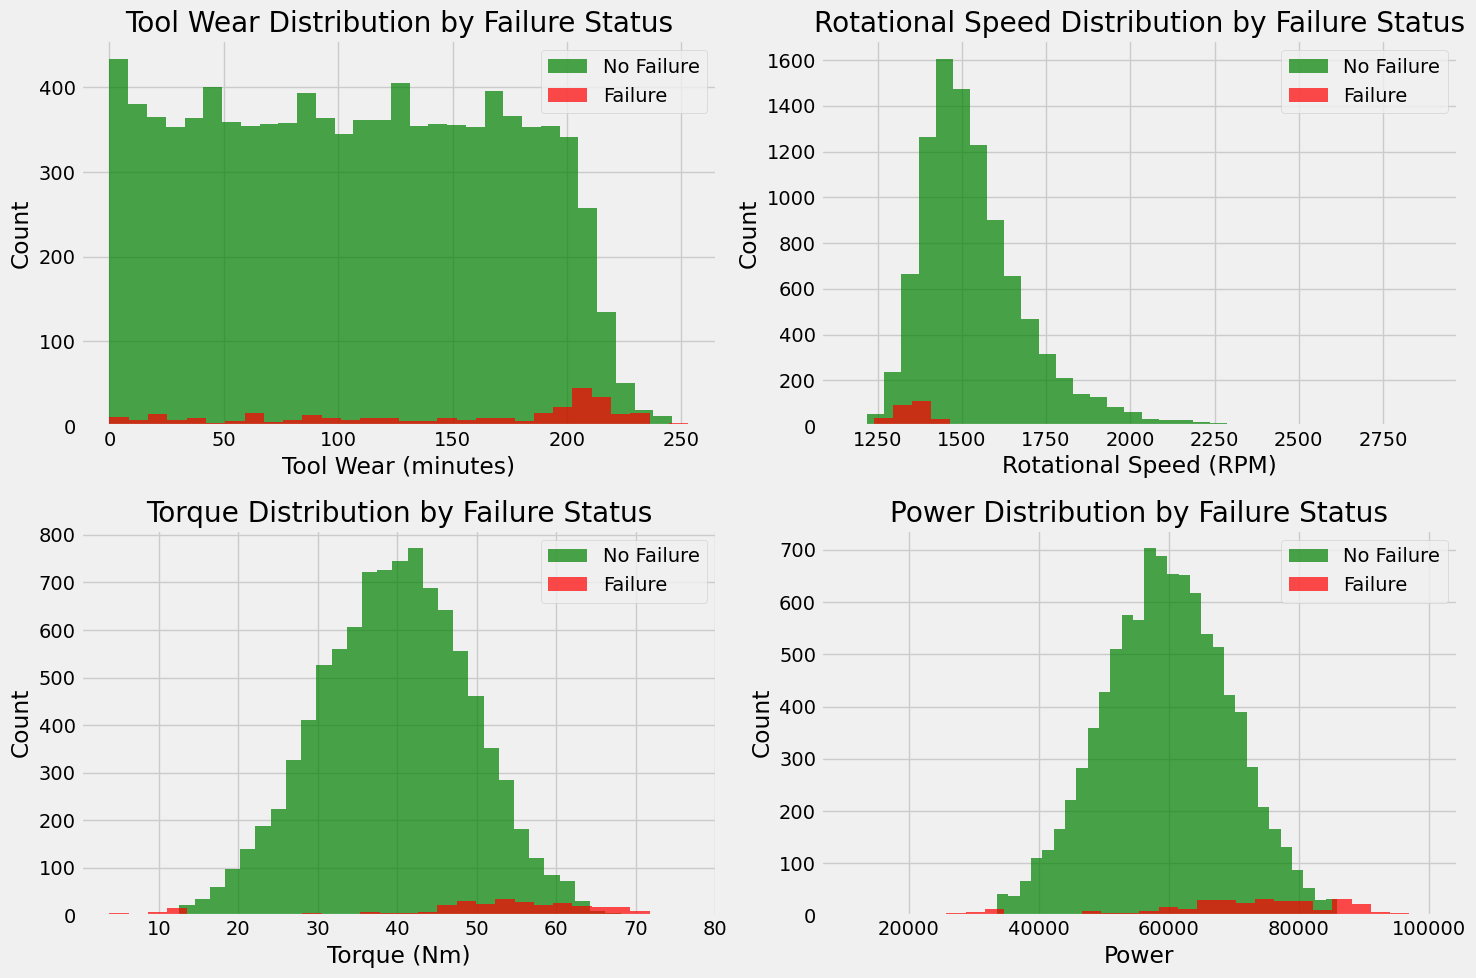

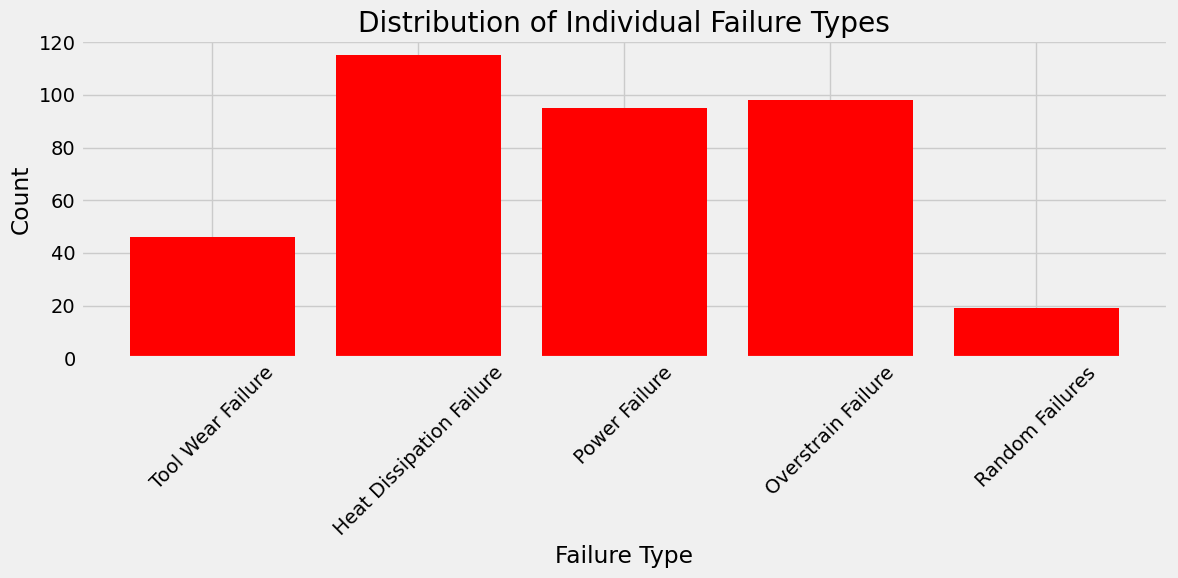

Individual failure type counts:
Tool Wear Failure: 46
Heat Dissipation Failure: 115
Power Failure: 95
Overstrain Failure: 98
Random Failures: 19


In [19]:
# Failure distribution
plt.figure(figsize=(10, 6))
failure_counts = y.value_counts()
plt.bar(['No Failure', 'Failure'], failure_counts.values, color=['green', 'red'])
plt.title('Equipment Failure Distribution')
plt.ylabel('Count')
for i, v in enumerate(failure_counts.values):
    plt.text(i, v + 20, str(v), ha='center')
plt.show()

print(f"Failure rate: {y.mean()*100:.2f}% (highly imbalanced)")

# Feature correlations with failure
correlations = X.corrwith(y).abs().sort_values(ascending=False)
top_correlations = correlations.head(8)

plt.figure(figsize=(12, 6))
top_correlations.plot(kind='bar', color='orange')
plt.title('Feature Correlation with Equipment Failure')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Top correlations with failure:")
for feature, corr in top_correlations.head(5).items():
    print(f"{feature}: {corr:.4f}")

# Feature distributions by failure status
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Tool wear
axes[0, 0].hist(X[y == 0]['Tool wear [min]'], bins=30, alpha=0.7, label='No Failure', color='green')
axes[0, 0].hist(X[y == 1]['Tool wear [min]'], bins=30, alpha=0.7, label='Failure', color='red')
axes[0, 0].set_title('Tool Wear Distribution by Failure Status')
axes[0, 0].set_xlabel('Tool Wear (minutes)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

# Rotational speed
axes[0, 1].hist(X[y == 0]['Rotational speed [rpm]'], bins=30, alpha=0.7, label='No Failure', color='green')
axes[0, 1].hist(X[y == 1]['Rotational speed [rpm]'], bins=30, alpha=0.7, label='Failure', color='red')
axes[0, 1].set_title('Rotational Speed Distribution by Failure Status')
axes[0, 1].set_xlabel('Rotational Speed (RPM)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

# Torque
axes[1, 0].hist(X[y == 0]['Torque [Nm]'], bins=30, alpha=0.7, label='No Failure', color='green')
axes[1, 0].hist(X[y == 1]['Torque [Nm]'], bins=30, alpha=0.7, label='Failure', color='red')
axes[1, 0].set_title('Torque Distribution by Failure Status')
axes[1, 0].set_xlabel('Torque (Nm)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# Power
axes[1, 1].hist(X[y == 0]['Power'], bins=30, alpha=0.7, label='No Failure', color='green')
axes[1, 1].hist(X[y == 1]['Power'], bins=30, alpha=0.7, label='Failure', color='red')
axes[1, 1].set_title('Power Distribution by Failure Status')
axes[1, 1].set_xlabel('Power')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

failure_columns = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_mapping = {
    'TWF': 'Tool Wear Failure',
    'HDF': 'Heat Dissipation Failure',
    'PWF': 'Power Failure',
    'OSF': 'Overstrain Failure', 
    'RNF': 'Random Failures'
}

failure_type_counts = {}
for col in failure_columns:
    failure_type_counts[failure_mapping[col]] = data[data[col] == 1].shape[0]

plt.bar(failure_type_counts.keys(), failure_type_counts.values(), color='red')
plt.title('Distribution of Individual Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Individual failure type counts:")
for failure_type, count in failure_type_counts.items():
    print(f"{failure_type}: {count}")

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Original failure rate in train: {y_train.mean():.4f}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"After SMOTE - Class distribution: {pd.Series(y_train_resampled).value_counts()}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


Train shape: (8000, 9), Test shape: (2000, 9)
Original failure rate in train: 0.0339
After SMOTE - Class distribution: Machine failure
0    7729
1    7729
Name: count, dtype: int64
